# Objective 2: Age Prediction
*Notebook 03_O2_AgePrediction*

## 1. 导入库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

## 2. 加载并预处理数据

In [2]:
df = pd.read_csv('../data/custom_covid19.csv')
df.replace([97,98,99], np.nan, inplace=True)
y = df['AGE']
X = df.drop(columns=['AGE','DATE_DIED'])
binary_cols = ['USMER','MEDICAL_UNIT','SEX','PATIENT_TYPE','INTUBED','PNEUMONIA',
               'PREGNANT','DIABETES','COPD','ASTHMA','INMSUPR','HYPERTENSION',
               'OTHER_DISEASE','CARDIOVASCULAR','OBESITY','RENAL_CHRONIC','TOBACCO',
               'TEST_RESULT','ICU']
for col in binary_cols:
    X[col] = X[col].map({1:1,2:0})
num_imputer = SimpleImputer(strategy='median')
X[X.columns] = num_imputer.fit_transform(X)
print("Any NaNs left in X?", X.isnull().any().any())

Any NaNs left in X? False


## 3. 划分训练集 / 验证集

In [3]:
# 特征预处理后，加上：
mask_age = y.notna()
X = X[mask_age]
y = y[mask_age]
print("After filtering, any NaNs in y?", y.isnull().any())

# 然后再：
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Validation shape:", X_val.shape)

After filtering, any NaNs in y? False
Train shape: (79975, 19) Validation shape: (19994, 19)


## 4. 基线模型

In [4]:
def eval_reg(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"--- {name} ---")
    print(f"R2   : {r2:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}\n")
lr = LinearRegression().fit(X_train, y_train)
eval_reg("Linear Regression", y_val, lr.predict(X_val))
dt = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
eval_reg("Decision Tree Regressor (default)", y_val, dt.predict(X_val))

--- Linear Regression ---
R2   : 0.2489
RMSE : 14.6741
MAE  : 11.4075

--- Decision Tree Regressor (default) ---
R2   : 0.2405
RMSE : 14.7557
MAE  : 11.4197



## 5. 超参数调优：Decision Tree & Random Forest

In [5]:
param_dt = {'max_depth':[3,5,7,10,15,20],'min_samples_split':[2,5,10],'ccp_alpha':[0.0,1e-4,1e-3]}
gs_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), param_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs_dt.fit(X_train, y_train)
best_dt = gs_dt.best_estimator_
print("Best DT params:", gs_dt.best_params_)
eval_reg("DT (tuned)", y_val, best_dt.predict(X_val))

param_rf = {'n_estimators':[50,100,200],'max_depth':[5,10,15],'min_samples_split':[2,5]}
gs_rf = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs_rf.fit(X_train, y_train)
best_rf = gs_rf.best_estimator_
print("Best RF params:", gs_rf.best_params_)
eval_reg("RF (tuned)", y_val, best_rf.predict(X_val))

Best DT params: {'ccp_alpha': 0.0, 'max_depth': 7, 'min_samples_split': 10}
--- DT (tuned) ---
R2   : 0.2563
RMSE : 14.6014
MAE  : 11.3223

Best RF params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
--- RF (tuned) ---
R2   : 0.2637
RMSE : 14.5286
MAE  : 11.2776



## 6. 保存最佳模型

In [6]:
joblib.dump(best_rf, 'best_age_model.pkl')
print("Best age model saved to best_age_model.pkl")

Best age model saved to best_age_model.pkl


## 7. （可选）生成 Mock-up 测试集

In [7]:
X_full, y_full = X.copy(), y.copy()
X_tr, X_mock, y_tr, y_mock = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
X_mock.to_csv('proj2-test-data.csv', index=False)
y_mock.to_csv('proj2-test-target.csv', index=False, header=False)
print("Mock-up test files generated.")

Mock-up test files generated.


## 8. 独立测试集验证

In [8]:
X_test = pd.read_csv('proj2-test-data.csv')
y_test = pd.read_csv('proj2-test-target.csv', header=None)[0]
X_test[X_test.columns] = num_imputer.transform(X_test)
best_age_model = joblib.load('best_age_model.pkl')
eval_reg("Final Age Model on Test Set", y_test, best_age_model.predict(X_test))

--- Final Age Model on Test Set ---
R2   : 0.2637
RMSE : 14.5286
MAE  : 11.2776



## 9.直方图

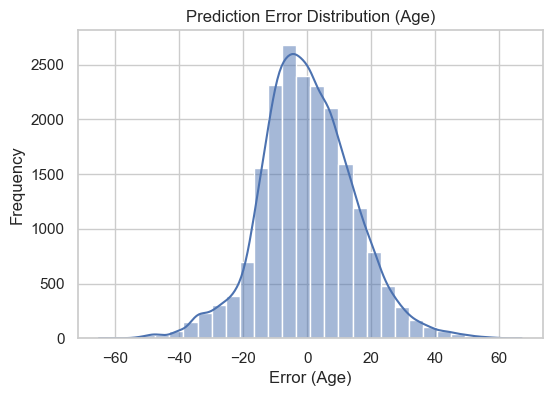

In [9]:
# 误差分布图（可选）
errors = y_test - best_age_model.predict(X_test)
plt.figure(figsize=(6,4))
sns.histplot(errors, bins=30, kde=True)
plt.title('Prediction Error Distribution (Age)')
plt.xlabel('Error (Age)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()